# Get data from kaggle

In [ ]:
# 1. Install Kaggle
!pip install -q kaggle

In [ ]:
# 2. Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
kaggle_creds_path = "/content/drive/MyDrive/Colab Notebooks/PDL/kaggle.json"

! mkdir ~/.kaggle
! cp '/content/drive/MyDrive/Colab Notebooks/PDL/kaggle.json' ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c hubmap-hacking-the-human-vasculature

! mkdir kaggle_data

100% 3.96G/3.97G [00:56<00:00, 124MB/s]
100% 3.97G/3.97G [00:56<00:00, 75.2MB/s]


In [ ]:
! unzip -qq '/content/hubmap-hacking-the-human-vasculature.zip' -d '/content/kaggle_data'

# Creating datasets
Source: https://www.kaggle.com/code/mersico/medical-instance-segmentation-with-yolov8

## Libraries

In [ ]:
from itertools import chain
import json
import os
import shutil
from tqdm.notebook import tqdm
import yaml
import numpy as np
import os, os.path
from pycocotools.coco import COCO
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

## COCO DATASET CREATION
Create COCO style dataset  
dataset

|_train  
|     |_images  
|     |_labels  
|  
|_test  
|     |_images  
|     |_labels  
|  
|_coco.yaml  
"

In [ ]:
class COCODataset:
    def __init__(self, images_path: str, annotations_filepath: str,
                 imdata_path: str, dataset_name: str = "dataset",
                 length: int = None, dataset_allowed: list[int] = [1, 2, 3]):
      # Inputs:
      #   images_path - path to image directory
      #   annotation_path - path to images annotation file
      #   imdata_path - path to file containing data about images
      #   length - size of dataset created
        self.dataset_name = dataset_name

        self.train_size = None
        self.val_size = None
        # dataset size
        self.length = length
        self.classes = None
        self.labels_counter = None
        self.normalize = None

        self.images_path = images_path
        self.annotations_filepath = annotations_filepath
        self.imdata_path = imdata_path

        self.dataset_dirpath = os.path.join(os.getcwd(), self.dataset_name)
        self.train_dirpath =  os.path.join(self.dataset_dirpath, "train")
        self.val_dirpath =  os.path.join(self.dataset_dirpath, "val")
        self.config_path = os.path.join(self.dataset_dirpath, "coco.yaml")

        self.sample_data = pd.read_csv(imdata_path)
        self.dataset_allowed = dataset_allowed

        self.classes_dict = {
            "blood_vessel": 0,
            "glomerulus": 1,
            "unsure": 2,
        }

        self.samples = self.parse_jsonl(annotations_filepath)
        if self.length == None:
            self.length = len(self.samples)
        self.__check_datasize()


    def __prepare_dirs(self) -> None:
      # Create structure for coco dataset
        if not os.path.exists(self.dataset_dirpath):
            os.makedirs(os.path.join(self.train_dirpath, "images"), exist_ok=True)
            os.makedirs(os.path.join(self.train_dirpath, "labels"), exist_ok=True)
            os.makedirs(os.path.join(self.val_dirpath, "images"), exist_ok=True)
            os.makedirs(os.path.join(self.val_dirpath, "labels"), exist_ok=True)
        else:
            raise RuntimeError()

    def __define_splitratio(self) -> None:
      # Set sizes for train and val datasets
        self.train_size = round(self.length * self.train_size)
        self.val_size = self.length - self.train_size
        assert self.train_size + self.val_size == self.length

    def __check_datasize(self) -> None:
        # Check if there is enough data fulfilling given condition to create given
        # dataset size
        found_samples = 0
        for i, line in tqdm(
                  enumerate(self.samples),
                  desc="Checking data", total=self.length
        ):
            if (self.__check_id(line["id"]) and
                self.__check_annotations(line["annotations"])
            ):
                found_samples += 1

        if found_samples < self.length:
            print("There is not enough data that fulfill given condition.\n",
                  "Do you want to turncate number of samples to: ",
                  found_samples, "?\n")
            inp = input("y/n \n")
            if inp == "y":
                self.length = found_samples
            else:
                raise RuntimeError("Not enough data to fulfill given conditions.")

    def __check_id(self, id: list) -> bool:
        if (self.sample_data.query("id=='"+id+"'")["dataset"].iloc[0]
            in self.dataset_allowed):
            return True
        return False

    def __check_annotations(self, annotations: list) -> bool:
        for annotation in annotations:
            if (annotation["type"] in self.classes_dict and
                annotation["coordinates"][0]):
                return True
        return False

    def __define_paths(self, i: int) -> dict:
      # Return train data path if i < train size
        data_path = self.val_dirpath
        if i < self.train_size:
            data_path = self.train_dirpath
        return {
            "images": os.path.join(data_path, "images"),
            "labels": os.path.join(data_path, "labels")
        }

    @staticmethod
    def __get_label_path(paths_dict: dict, identifier: str) -> str:
        return os.path.join(
            paths_dict["labels"],
            f"{identifier}.txt"
        )

    @staticmethod
    def __get_image_path(paths_dict: dict, identifier: str) -> str:
        return os.path.join(
            paths_dict["images"],
            f"{identifier}.tif"
        )

    def __copy_image(self, dst_path: str, identifier: str) -> str:
        shutil.copyfile(
            os.path.join(self.images_path, f"{identifier}.tif"),
            dst_path
        )

    def __copy_label(self, dst_path: str, annotations: list) -> None:
        with open(dst_path, "w") as file:
            duplicate_labels = 0
            used_coords = []
            for annotation in annotations:
                coordinates = annotation["coordinates"][0]
                label = self.classes_dict[annotation["type"]]
                if label in self.classes:
                  # apparently some annotations are doubled
                    if coordinates:
                        if self.normalize:
                            coordinates = np.array(coordinates) / 512.0
                        used_coords.append(coordinates)
                        coordinates = " ".join(map(str, chain(*coordinates)))
                        if coordinates in used_coords:
                            duplicate_labels += 1
                            continue
                        used_coords.append(coordinates)
                        file.write(f"{label} {coordinates}\n")
                        self.labels_counter += 1
        if duplicate_labels:
            print(f"Warning! Dropping {duplicate_labels} duplicated labels from file: ", dst_path)

    def __splitfolders(self):
        found_samples = 0

        pbar = tqdm(total=self.length, desc = "Dataset creation")

        for line in self.samples:
            self.labels_counter = 0
            identifier = line["id"]
            annotations = line["annotations"]
            paths_dict = self.__define_paths(found_samples)
            if (self.__check_id(identifier) and
                self.__check_annotations(annotations)
                ):
                found_samples += 1
                pbar.update(1)

                dst_image_path = self.__get_image_path(paths_dict, identifier)
                dst_label_path = self.__get_label_path(paths_dict, identifier)

                self.__copy_image(dst_image_path, identifier)
                self.__copy_label(dst_label_path, annotations)
            if found_samples >= self.length: break

        pbar.close()
        if found_samples < self.length:
            raise RuntimeError("Not enough samples to create dataset")

    def __count_dataset(self) -> dict:
        train_images = len(os.listdir(os.path.join(self.train_dirpath, "images")))
        train_labels = len(os.listdir(os.path.join(self.train_dirpath, "labels")))
        val_images = len(os.listdir(os.path.join(self.val_dirpath, "images")))
        val_labels = len(os.listdir(os.path.join(self.val_dirpath, "labels")))
        return {
            "train_images": train_images,
            "train_labels": train_labels,
            "val_images": val_images,
            "val_labels": val_labels
        }

    @staticmethod
    def __check_sanity(count_dict: dict) -> None:
        assert count_dict["train_images"] == count_dict["train_labels"]
        assert count_dict["val_images"] == count_dict["val_labels"]

    def parse_jsonl(self, path: str) -> list[dict]:
        with open(path, 'r') as json_file:
            jsonl_samples = [
                json.loads(line)
                for line in tqdm(
                    json_file, desc="Processing polygons"
                )
            ]
        print("Found " + str(len(jsonl_samples))+ " samples containing polygons.")
        return jsonl_samples

    def get_config(self) ->dict:
        names = ["blood_vessel", "glomerulus", "unsure"]
        return {
            "train": str(self.train_dirpath),
            "val": str(self.val_dirpath),
            "names": [names[i] for i in self.classes]
        }

    def write_config(self, config: dict) -> None:
        with open(self.config_path, mode="w") as f:
            yaml.safe_dump(stream=f, data=config)

    def __call__(self, train_size: float,
                 classes: list[int],
                 make_config: bool = True,
                 normalize: bool = True
                ) -> None:

        self.train_size = train_size
        self.classes = classes
        self.normalize = normalize

        self.__define_splitratio()
        try:
            self.__prepare_dirs()
        except RuntimeError:
            inp = input("Dataset with name "+self.dataset_name+" already exists.\n"+
            "Do you want to override old dataset? y/n \n")
            if inp == "y":
                shutil.rmtree(self.dataset_name)
                self.__prepare_dirs()
            else: raise RuntimeError("Dataset already exists!")

        self.__splitfolders()
        count_dict = self.__count_dataset()
        print(count_dict)
        self.__check_sanity(count_dict)

        if make_config:
            config = self.get_config()
            self.write_config(config)


In [ ]:
coco = COCODataset(
  annotations_filepath="kaggle_data/polygons.jsonl",
  images_path="kaggle_data/train",
  imdata_path = "kaggle_data/tile_meta.csv",
  dataset_name = "COCOdataset"
)

coco(train_size=0.85, classes=[0, 1, 2], normalize=True)

Processing polygons: 0it [00:00, ?it/s]

Found 1633 samples containing polygons.


Checking data:   0%|          | 0/1633 [00:00<?, ?it/s]

Dataset creation:   0%|          | 0/1633 [00:00<?, ?it/s]

{'train_images': 1388, 'train_labels': 1388, 'val_images': 245, 'val_labels': 245}


In [ ]:
!zip -r -qq CDataset.zip COCOdataset
shutil.copy("CDataset.zip","drive/MyDrive/Colab Notebooks/PDL")

## Standard dataset
Dataset with labeled and unlabeled data, annotations are converted to masks. Used for semantic segmentation only.

In [ ]:
class SDataset:
    def __init__(self, images_path: str, annotations_filepath: str,
                imdata_path: str, dataset_name: str = "SHdataset",
               num_classes:int = 3, image_size = (512, 512), allow_unlabeled:bool = False):
        # Inputs:
        #   images_path - path to image directory
        #   annotation_path - path to images annotation file
        #   imdata_path - path to file containing data about images
        self.allow_unlabeled = allow_unlabeled
        self.split_mask_to_instances = False
        self.dataset_name = dataset_name
        self.image_size = image_size
        self.images_path = images_path
        self.annotations_filepath = annotations_filepath
        self.imdata_path = imdata_path

        self.dataset_dirpath = os.path.join(os.getcwd(), self.dataset_name)

        self.labeled_dirpath =  os.path.join(self.dataset_dirpath, "labeled")
        if self.allow_unlabeled:
          self.unlabeled_dirpath =  os.path.join(self.dataset_dirpath, "unlabeled")

        self.sample_data = pd.read_csv(imdata_path)
        self.num_classes = num_classes

        self.classes_dict = {
            "blood_vessel": 0,
            "glomerulus": 1,
            "unsure": 2,
        }

        self.polygons = dict((item['id'], item) for item
                             in self.parse_jsonl(annotations_filepath))


    def parse_jsonl(self, path: str) -> list[dict]:
        with open(path, 'r') as json_file:
            jsonl_samples = [
                json.loads(line)
                for line in tqdm(
                    json_file, desc="Processing polygons"
                )
            ]
        print("Found " + str(len(jsonl_samples))+ " samples containing polygons.")
        return jsonl_samples


    def __prepare_dirs(self) -> None:
        # Create structure for coco dataset
        if not os.path.exists(self.dataset_dirpath):
          os.makedirs(os.path.join(self.labeled_dirpath, "images"), exist_ok=True)
          os.makedirs(os.path.join(self.labeled_dirpath, "masks"), exist_ok=True)
          if self.split_mask_to_instances:
            os.makedirs(os.path.join(self.labeled_dirpath, "instances"), exist_ok=True)
          if self.allow_unlabeled:
            os.makedirs(os.path.join(self.unlabeled_dirpath, "images"), exist_ok=True)
        else:
            raise RuntimeError()


    @staticmethod
    def __copy_image(source: str, destination:str) -> str:
        shutil.copyfile(
          source,
          destination
        )


    @staticmethod
    def __save_mask(dst_path:str, file_name:str, mask: np.ndarray) -> None:
        np.save(os.path.join(dst_path,file_name), mask)


    def __instances_from_annotation(self, annotations: dict,
                         size: tuple[int, int])->np.ndarray:
        masks = {
        0: [],
        1: [],
        2: []
        }
        for annotation in annotations:
            mask = Image.new(mode='1', size=size)
            en_type = self.classes_dict[annotation["type"]]
            coords = np.ravel(np.array(annotation["coordinates"][0]))
            ImageDraw.Draw(mask, '1').polygon(coords.tolist(), fill=(1))
            masks[en_type].append(np.array(mask))
        return np.array(masks)

    def __mask_from_annotation(self, annotations: dict,
                             size: tuple[int, int])->np.ndarray:
        masks = [Image.new(mode='1', size=size) for i in range(self.num_classes)]
        for annotation in annotations:
            en_type = self.classes_dict[annotation["type"]]
            coords = np.ravel(np.array(annotation["coordinates"][0]))
            ImageDraw.Draw(masks[en_type], '1').polygon(coords.tolist(), fill=(1))
        return np.stack([np.array(mask) for mask in masks], axis=2).astype(float)


    def __split_folders(self)->None:
        if self.allow_unlabeled:
          pbar = tqdm(desc="Preparing data", total=self.sample_data.shape[0])
        else:
          pbar = tqdm(desc="Preparing data", total=len(self.polygons))

        for sample_id, sample_dataset in zip(self.sample_data['id'],
                                             self.sample_data['dataset']):
            impath = os.path.join(self.images_path, f"{sample_id}.tif")
            if sample_dataset in [1, 2]:
                dest_path = self.labeled_dirpath
            elif sample_dataset == 3:
                if self.allow_unlabeled:
                  dest_path = self.unlabeled_dirpath
                else: continue
            else:
                raise RuntimeError(f"Unknown sample dataset for sample {sample_id}")

            self.__copy_image(impath, os.path.join(dest_path, "images", f"{sample_id}.tif"))

            if sample_dataset in [1,2]:
                annotations = self.polygons.get(sample_id).get("annotations")
                mask = self.__mask_from_annotation(annotations, self.image_size)
                self.__save_mask(os.path.join(dest_path, "masks"), sample_id, mask)
                if self.split_mask_to_instances:
                  instances = self.__instances_from_annotation(annotations, self.image_size)
                  self.__save_mask(os.path.join(dest_path, "instances"), sample_id, instances)
            pbar.update(1)
        pbar.close()


    def __count_dataset(self) -> dict:
        labeled_images = len(os.listdir(os.path.join(self.labeled_dirpath, "images")))
        labeled_masks = len(os.listdir(os.path.join(self.labeled_dirpath, "masks")))
        if self.allow_unlabeled:
          unlabeled_images = len(os.listdir(os.path.join(self.unlabeled_dirpath, "images")))
          return {
            "labeled_images": labeled_images,
            "labeled_masks": labeled_masks,
            "unlabeled_images": unlabeled_images
          }
        else:
          return {
          "labeled_images": labeled_images,
          "labeled_masks": labeled_masks
        }


    @staticmethod
    def print_dataset(dataset:dict)->None:
        for k in dataset:
            print(f"{k}: {dataset[k]}\n")

    @staticmethod
    def __check_sanity(count_dict: dict) -> None:
        assert count_dict["labeled_images"] == count_dict["labeled_masks"]


    def create_dataset(self):
        try:
            self.__prepare_dirs()
        except RuntimeError:
            inp = input("Dataset with name "+self.dataset_name+" already exists.\n"+
                          "Do you want to override old dataset? y/n \n")
            if inp == "y":
                shutil.rmtree(self.dataset_name)
                self.__prepare_dirs()
            else: raise RuntimeError("Dataset already exists!")

        self.__split_folders()
        count_dict = self.__count_dataset()
        self.__check_sanity(count_dict)
        self.print_dataset(count_dict)

In [ ]:
ds = SDataset(
  annotations_filepath="kaggle_data/polygons.jsonl",
  images_path="kaggle_data/train",
  imdata_path = "kaggle_data/tile_meta.csv",
)

ds.create_dataset()

Processing polygons: 0it [00:00, ?it/s]

Found 1633 samples containing polygons.


Preparing data:   0%|          | 0/7033 [00:00<?, ?it/s]

labeled_images: 1633

labeled_masks: 1633



In [ ]:
!zip -r SHDataset.zip SHdataset

In [ ]:
shutil.copy("SHDataset.zip","drive/MyDrive/Colab Notebooks/PDL")

'drive/MyDrive/Colab Notebooks/PDL/SHDataset.zip'

# Load created dataset

In [ ]:
# 2. Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
import shutil
shutil.copy("/content/drive/MyDrive/Colab Notebooks/PDL/SDataset.zip", "/content")

'/content/SDataset.zip'

In [ ]:
! unzip 'SDataset.zip'

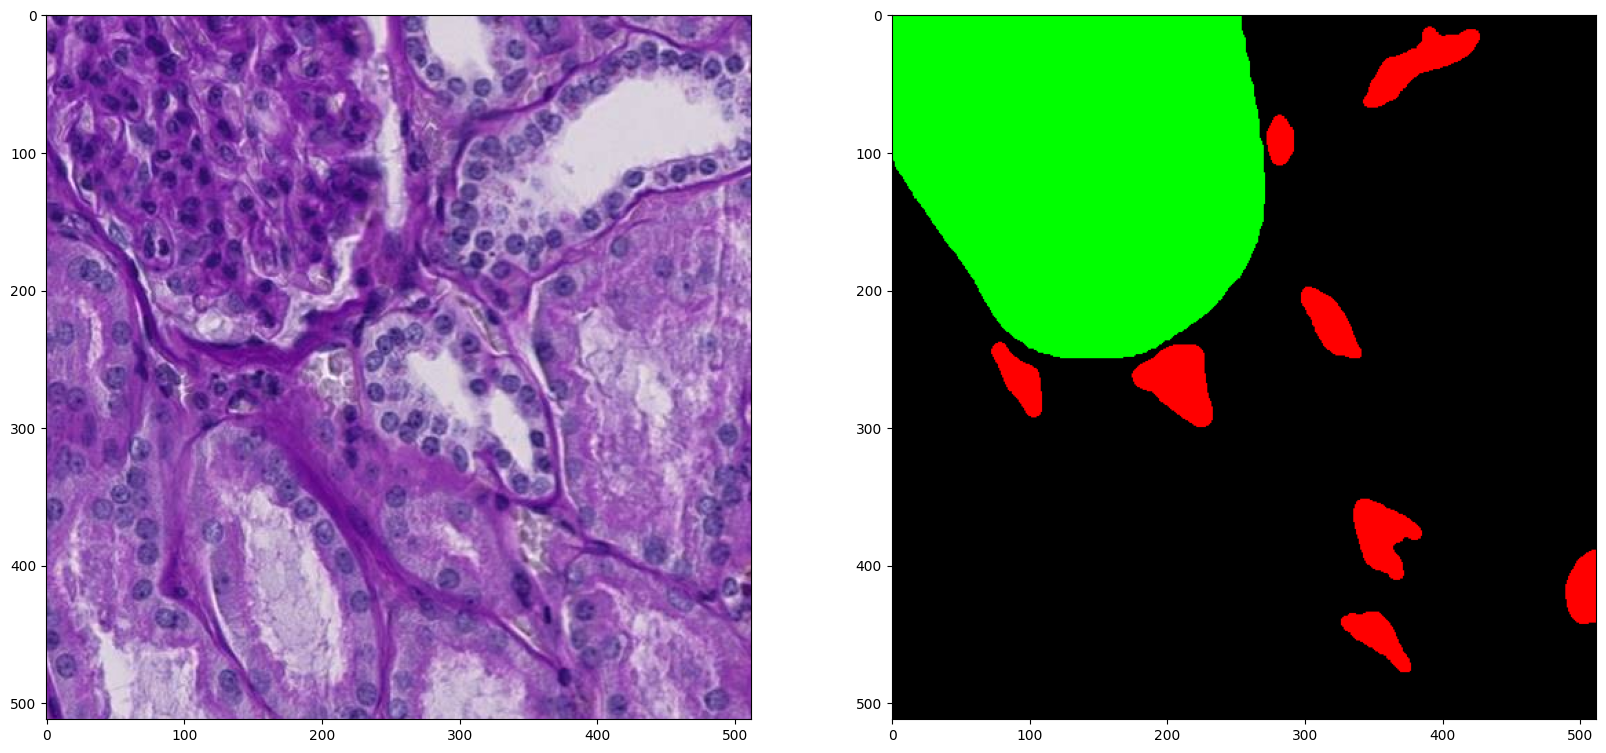

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
fig, ax = plt.subplots(1,2, figsize = (20, 10))
im = Image.open('Sdataset/normal/images/0006ff2aa7cd.tif')
ms = np.load("Sdataset/normal/masks/0006ff2aa7cd.npy")
ax[0].imshow(im)
ax[1].imshow(ms)
plt.show()

# EDA - Exploratory data analysis

In [ ]:
tile_data = pd.read_csv('/content/kaggle_data/tile_meta.csv')
tile_data.head()

In [ ]:
print("Number of images in val data: ", tile_data.size)
# We know that there are 3 types of dataset in provided data,
# dataset 1 contains fully annoted examples
# dataset 2 contains remaining tiles and contains spare annotations that haven't been revieved by expert
# dataset 3 - well there is also that (dunno, todo: info)

print("Dataset 1 size: ", len(tile_data[tile_data['dataset']==1]))
print("Dataset 2 size: ", len(tile_data[tile_data['dataset']==2]))
print("Dataset 3 size: ", len(tile_data[tile_data['dataset']==3]))

In [ ]:
# Load csv data about samples and polygon data
samples_pd = pd.read_csv("kaggle_data/tile_meta.csv")
samples_jsonl = coco.parse_jsonl("kaggle_data/polygons.jsonl")
samples_pd.head()

Processing polygons: 0it [00:00, ?it/s]

Found 1633 samples containing polygons.


id  source_wsi  dataset      i      j
0  0006ff2aa7cd           2        2  16896  16420
1  000e79e206b7           6        3  10240  29184
2  00168d1b7522           2        2  14848  14884
3  00176a88fdb0           7        3  14848  25088
4  0033bbc76b6b           1        1  10240  43008

In [ ]:
# Add info about availability of polygons for each sample in data
ids_with_polygons = [d['id'] for d in samples_jsonl]
has_polygons = []

blood_vessel = []
glomerulus = []
unsure = []

for sample in samples_pd["id"].to_list():
  bv, gl, un = [0, 0, 0]

  if sample in ids_with_polygons:
    has_polygons.append(1)
    ind = ids_with_polygons.index(sample)
    for annotation in samples_jsonl[ind]['annotations']:
      if annotation['type'] == "blood_vessel":
        bv += 1
      elif annotation['type'] == "glomerulus":
        gl += 1
      elif annotation['type'] == "unsure":
        un += 1
      else: raise RuntimeError("Unknown entity type found.")
  else:
    has_polygons.append(0)

  blood_vessel.append(bv)
  glomerulus.append(gl)
  unsure.append(un)

samples_pd["has_polygons"] = has_polygons
samples_pd["blood_vessels"] = blood_vessel
samples_pd["glomeruluses"] = glomerulus
samples_pd["unsures"] = unsure

samples_pd.head()

id  source_wsi  dataset      i      j  has_polygons  \
0  0006ff2aa7cd           2        2  16896  16420             1   
1  000e79e206b7           6        3  10240  29184             0   
2  00168d1b7522           2        2  14848  14884             1   
3  00176a88fdb0           7        3  14848  25088             0   
4  0033bbc76b6b           1        1  10240  43008             1   

   blood_vessels  glomeruluses  unsures  
0              8             1        0  
1              0             0        0  
2              1             1        0  
3              0             0        0  
4              3             0        1

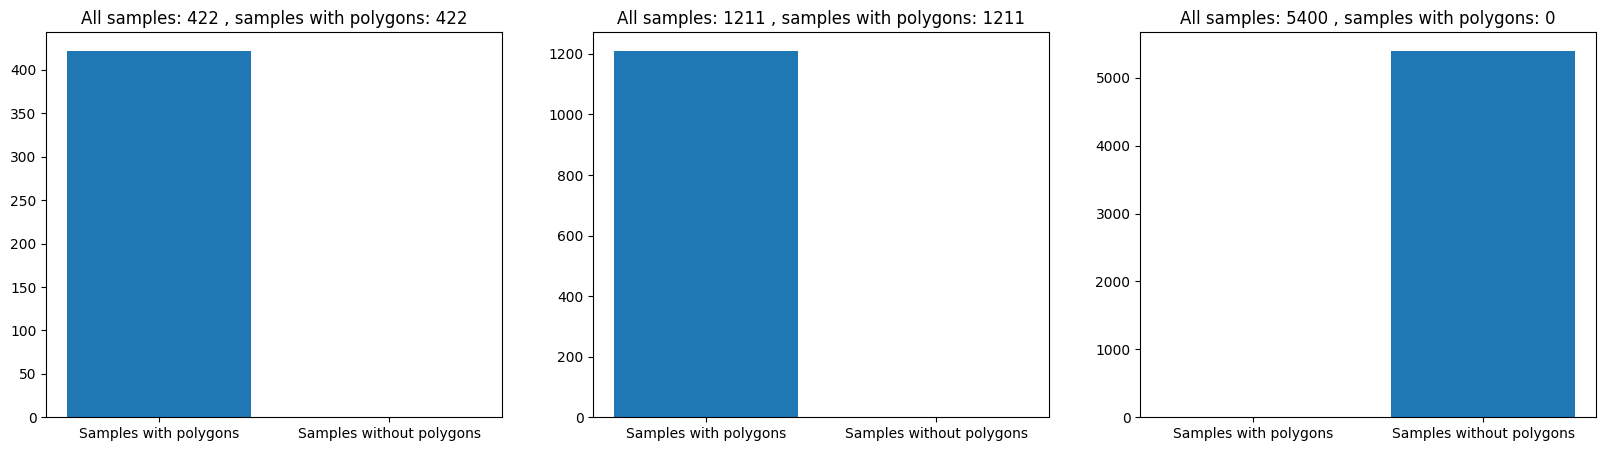

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,3, figsize=(20,5))
ax = axes.ravel()
for i in [1,2,3]:
  all_samples = (samples_pd.dataset == i).sum()
  samples_w_pol = samples_pd.loc[samples_pd["dataset"] == i, "has_polygons"].sum()
  title = "All samples: " + str(all_samples)+ " , samples with polygons: " + str(samples_w_pol)
  ax[i-1].set_title(title)
  ax[i-1].bar(["Samples with polygons", "Samples without polygons"], [samples_w_pol, all_samples - samples_w_pol])

All samples in datasets 1 and 2 are labeled, and we do know from competition information that datasets 1 contains tiles labeled by experts, while dataset 2 contains tiles that were not expert-revised.

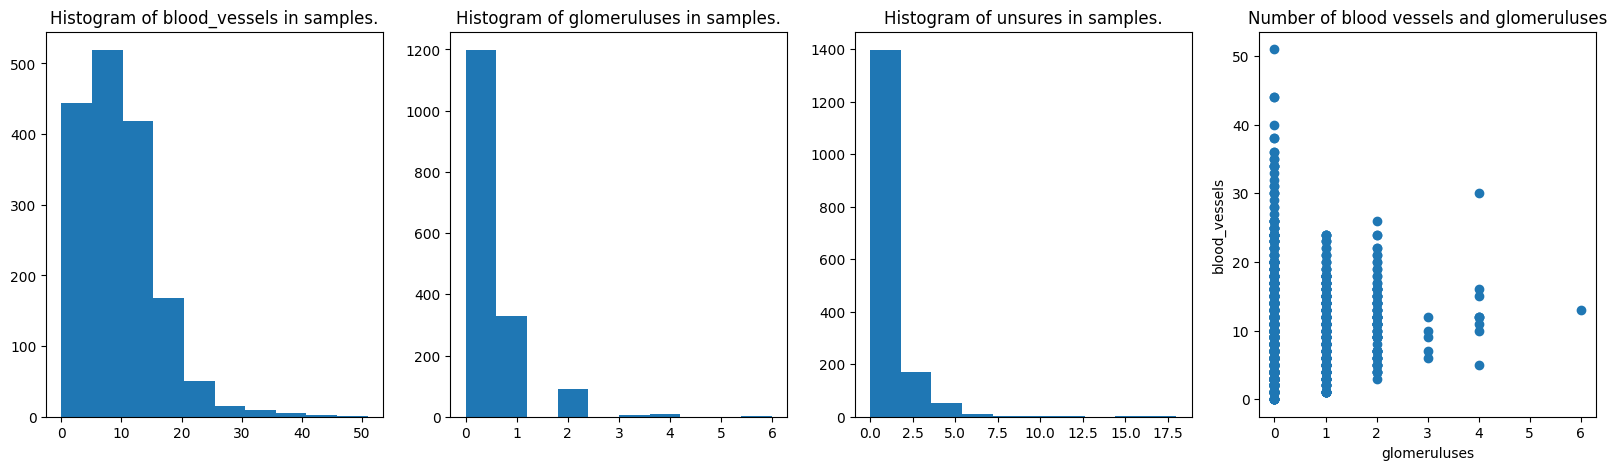

In [ ]:
annoted_pd = samples_pd[samples_pd['has_polygons']==1]
types = ['blood_vessels','glomeruluses','unsures']

fig, ax = plt.subplots(1,4, figsize=(20, 5))
ax.ravel()
for i, en_type in enumerate(types):
  ax[i].hist(annoted_pd[en_type].to_list())
  ax[i].set_title("Histogram of "+en_type+" in samples.")

ax[i+1].scatter(annoted_pd['glomeruluses'].to_list(), annoted_pd['blood_vessels'].to_list())
ax[i+1].set_xlabel("glomeruluses")
ax[i+1].set_ylabel("blood_vessels")
ax[i+1].set_title("Number of blood vessels and glomeruluses")

fig.show()

## Mean and std for images


## Plotting data

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [ ]:
class ImageCollection():
  def __init__(self, images_path: str, annotations_filepath: str,
               annotation_filetype: str = '.txt', image_filetype: str = '.tif',
               normalized_coordinates: bool = True, normalized = False):
    self.normalized_coordinates = normalized_coordinates

    self.images_path = images_path
    self.normalized = normalized
    self.image_filetype = image_filetype
    self.annotations_filepath = annotations_filepath
    self.annotation_filetype = annotation_filetype

    self.fileList = [os.path.splitext(im) for im in os.listdir(images_path)]
    self.current_image_id = 0

    self.current_image = None
    self.current_annotation = []
    self.annoted_image = None

    self.next()

  def __load_image(self, image_name: str = None) -> None:
    if not image_name:
      current_image_path = (self.images_path+ "/" +
                            ''.join(self.fileList[self.current_image_id]))
      self.current_image = Image.open(current_image_path)
    else:
      current_image_path = (self.images_path+ "/" + image_name +
                            self.image_filetype)
      self.current_image = Image.open(current_image_path)

  def __load_annotation(self, image_name: str = None) -> None:
    self.current_annotation = []
    self.annoted_image = self.current_image.copy()
    if not image_name:
      current_annotation_path = (self.annotations_filepath + "/" +
                                self.fileList[self.current_image_id][0] +
                                self.annotation_filetype)
    else:
      current_annotation_path = (self.annotations_filepath + "/" +
                                image_name +
                                self.annotation_filetype)

    with open(current_annotation_path) as annotations:
      for line in annotations:
        annotation = line.split(' ')
        en_type = int(annotation[0])
        if self.normalized:
          coords = [int(float(x)*512) for x in annotation[1:]]
        else:
          coords = [int(float(x)) for x in annotation[1:]]

        self.current_annotation.append({'type': en_type,
                                        'coords': coords})

  def __create_annotation_layer(self):
    for annotation in self.current_annotation:
      if annotation["type"] == 0:
        ImageDraw.Draw(self.annoted_image, 'RGBA').polygon(annotation["coords"],
                                          fill=(0, 255, 255, 128))
      elif annotation["type"] == 1:
        ImageDraw.Draw(self.annoted_image, 'RGBA').polygon(annotation["coords"],
                                               fill=(255, 0, 255, 128))
      else:
        ImageDraw.Draw(self.annoted_image, 'RGBA').polygon(annotation["coords"],
                                               fill=(255, 255, 0, 128))

  def display_current_image(self, axes = None) -> None:
    if not axes:
      fig, ax = plt.subplots(1,2, figsize=(15,8))
      fig.suptitle("Image: "+self.fileList[self.current_image_id][0])
      ax[0].imshow(self.current_image)
      ax[1].imshow(self.annoted_image)
    elif len(axes) == 2:
      axes[0].imshow(self.current_image)
      axes[1].imshow(self.annoted_image)
    elif len(axes) == 1:
      axes.imshow(self.annoted_image)

  def next(self) -> None:
    self.__load_image()
    self.__load_annotation()
    self.__create_annotation_layer()
    self.display_current_image()
    self.current_image_id += 1

  def display_image(self, image_id: str, axes = None) -> None:

    self.__load_image(image_id)
    self.__load_annotation(image_id)

    self.__create_annotation_layer()
    self.display_current_image(axes)

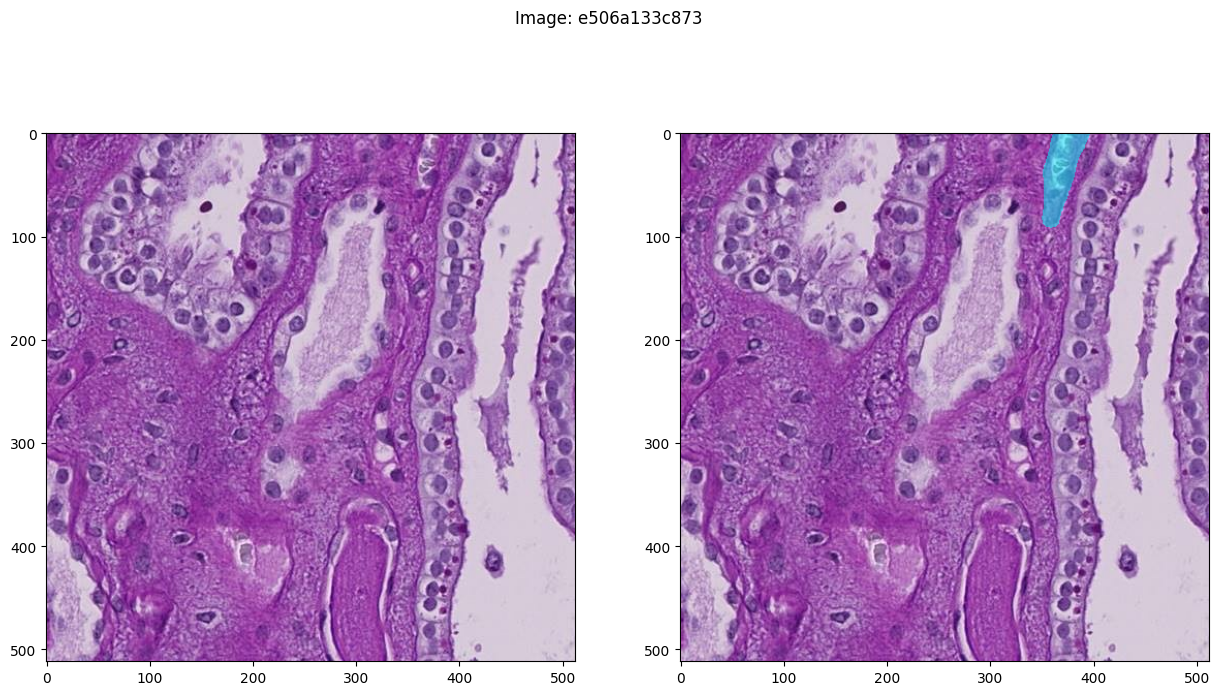

In [ ]:
image_collection = ImageCollection("/content/dataset/val/images", "/content/dataset/val/labels")

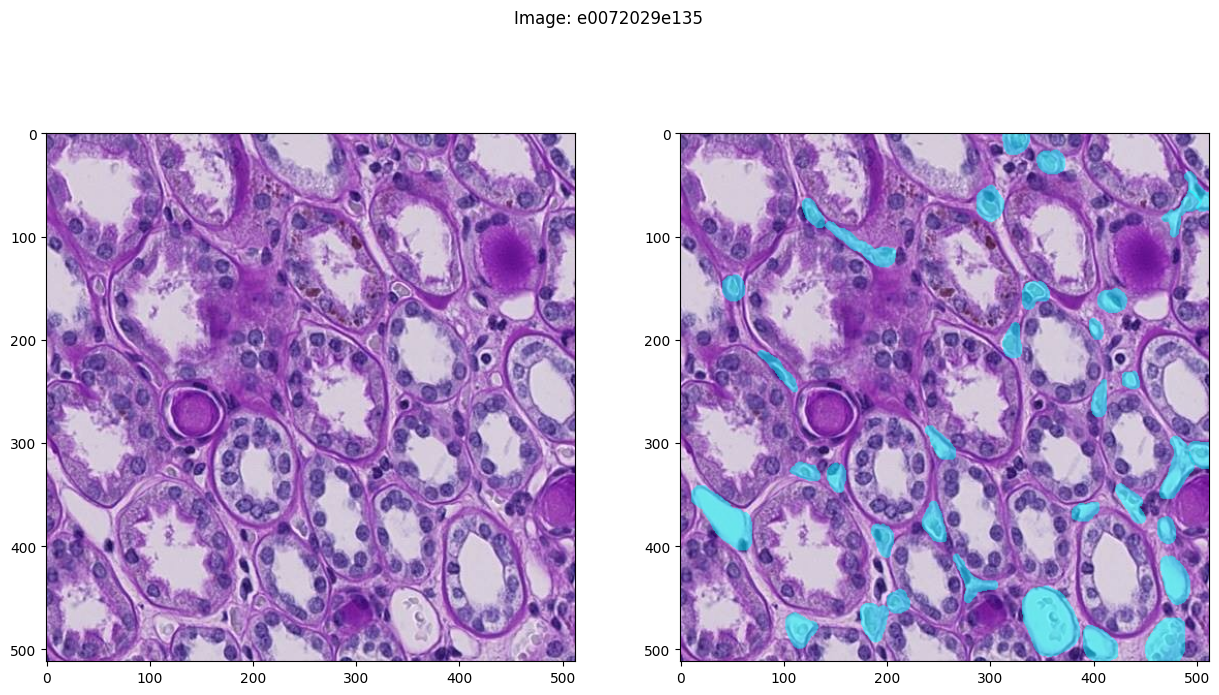

In [ ]:
image_collection.next()

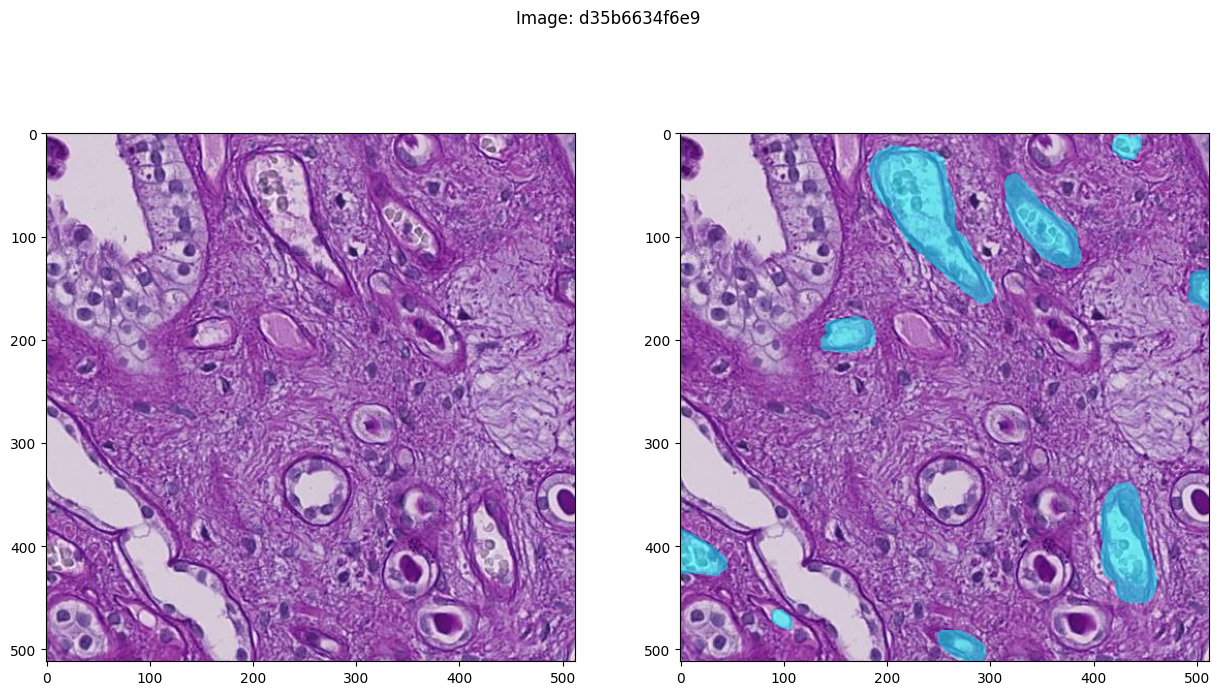

In [ ]:
image_collection.display_image("d9808586aef2")